# Advanced Lane Finding

Udacity Self-Driving Car Nanodegree Project 4

Ed Voas

First, initialize everything we need and define some useful functions for display.

In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

import glob
import json
import os

In [56]:
def show_before_and_after(before_image, after_image, before_title = "Before", after_title="After"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    if len(before_image.shape) == 3:
        ax1.imshow(before_image)
    else:
        ax1.imshow(before_image, cmap='gray')
    ax1.set_title(before_title, fontsize=20)
    if len(after_image.shape) == 3:
        ax2.imshow(after_image)
    else:
        ax2.imshow(after_image, cmap='gray')
    ax2.set_title(after_title, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
    
def draw_polyline(img, lines, color=[255, 0, 0], thickness=2):
    if len(lines) < 2:
        return
    
    lastPt = lines[0]
    for currPt in lines[1:]:
        cv2.line(img, (lastPt[0], lastPt[1]), (currPt[0], currPt[1]), color, thickness)
        lastPt = currPt

## Step 1: Calibration

First, we need to perform camera calibration to undo any camera distortion. Typically, any dash cam is going to have a wide field-of-view, and that causes warping. So we want to undo that so that we can more correctly measure curve radii.

First, let's look at a test image.

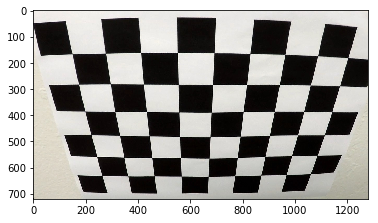

In [57]:
img = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(img)

Now we'll do a quick test of our corner detection.

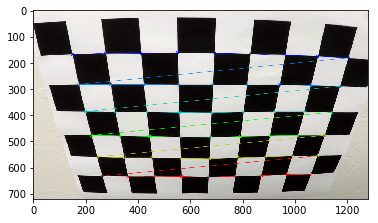

In [58]:
gridSize = (9, 6)

objp = np.zeros((gridSize[0] * gridSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:gridSize[0], 0:gridSize[1]].T.reshape(-1, 2)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

ret, corners = cv2.findChessboardCorners(gray, gridSize, None)
if ret:
    img2 = cv2.drawChessboardCorners(img, gridSize, corners, ret)
    plt.imshow(img2)

Next, we define a function to calibrate the camera and test it.

In [59]:
def calibrate_camera(images, grid_size, image_size):
    objpoints = []
    imgpoints = []

    objp = np.zeros((grid_size[0] * grid_size[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1, 2)

    for filename in images:
        img = mpimg.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            print("Unable to find appropriate number of corners on " + filename)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

    return mtx, dist

In [60]:
images = glob.glob('camera_cal/calibration*.jpg')
gridSize = (9, 6)
mtx, dist = calibrate_camera(images, gridSize, gray.shape[::-1])

Unable to find appropriate number of corners on camera_cal/calibration1.jpg
Unable to find appropriate number of corners on camera_cal/calibration4.jpg
Unable to find appropriate number of corners on camera_cal/calibration5.jpg


As you can see, some images can't be used for calibration as we can't find the requisite number of corners.

Now that calibration is complete, we test out our fix against one of the images.

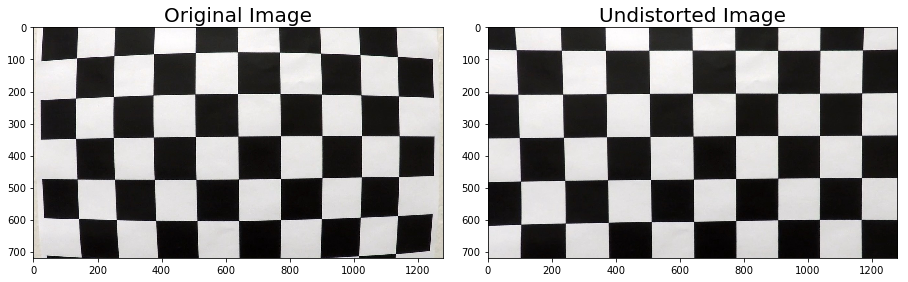

In [61]:
img = mpimg.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

show_before_and_after(img, dst, before_title="Original Image", after_title = "Undistorted Image")

Now we try it out on a real test image. It's admittedly harder to see the difference in a real image.

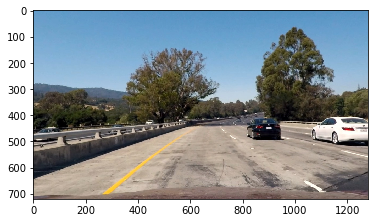

In [62]:
img = mpimg.imread('test_images/test1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

mpimg.imsave('output_images/pipe1.jpg', dst)
plt.imshow(dst)

In [63]:
def read_and_undistort(filename):
    image = mpimg.imread(filename)
    if image.shape[2] == 4:
        image = image[:,:,:3]
        
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

## Transform Image for Line Detection

We need to somehow make the lines stand out so we can run a detection algorithm later. There are two things we're trying here. Sobel and color thresholding. These are the functions I use later. 

In [64]:
ksize = 3

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        d = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        d = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_d = np.absolute(d)
    scaled = np.uint8(255*abs_d/np.max(abs_d))
    
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    mag = np.sqrt(sobelx **2 + sobely ** 2)
    
    scaled_sobel = np.uint8(255*mag/np.max(mag))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)

    dir = np.arctan2(abs_y, abs_x)
    
    binary_output = np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_output

def hls_channel_threshold(img, channel="h", thresh = (0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'h':
        channel_data = hls[:,:,0]
    elif channel == 'l':
        channel_data = hls[:,:,1]
    else:
        channel_data = hls[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1

    return binary

def rgb_channel_threshold(img, channel="r", thresh = (0, 255)):
    if channel == 'r':
        channel_data = img[:,:,0]
    elif channel == 'g':
        channel_data = img[:,:,1]
    else:
        channel_data = img[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1

    return binary

def hsv_channel_threshold(img, channel="h", thresh = (0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if channel == 'h':
        channel_data = hsv[:,:,0]
    elif channel == 's':
        channel_data = hsv[:,:,1]
    else:
        channel_data = hsv[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1

    return binary

Now we look at each one separately. I also added some interaction so I could play with the parameters. This comes in handy later when I use this to help adjust the settings we need for the rest of the notebook.

### Saturation (HLS)

<function __main__.f>

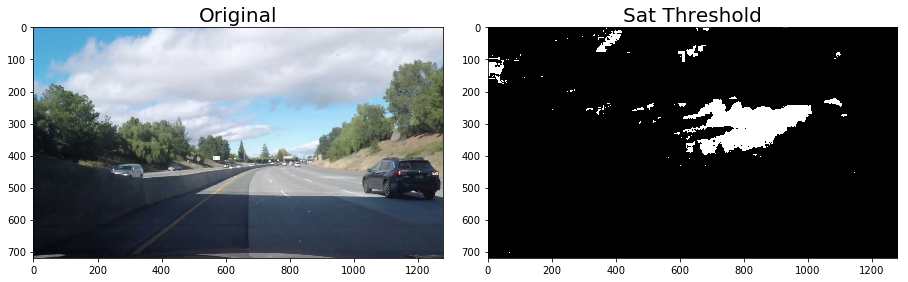

In [65]:
from ipywidgets import widgets
from ipywidgets import interact

image = read_and_undistort('test_images/shadow.jpg')

def f(x, y):
    color_binary = hls_channel_threshold(image, 's', thresh=(x, y))
    show_before_and_after(image, color_binary, before_title="Original", after_title="Sat Threshold")

interact(f, x=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min Color:"),
              y=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

### Lightness (HLS)

<function __main__.f>

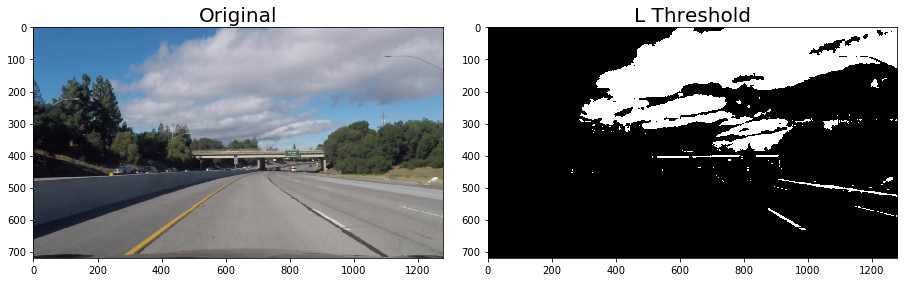

In [66]:
image = mpimg.imread('test_images/challenge_video.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

def f(x, y):
    color_binary = hls_channel_threshold(image, 'l', thresh=(x, y))
    show_before_and_after(image, color_binary, before_title="Original", after_title="L Threshold")

interact(f, x=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min Color:"),
              y=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

### Red Channel

<function __main__.f>

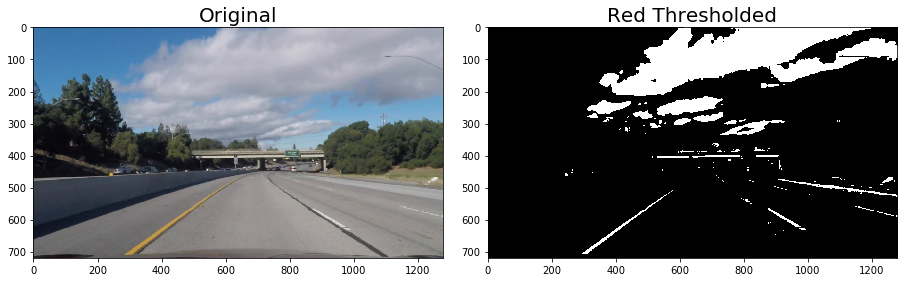

In [67]:
image = read_and_undistort('test_images/challenge_video.jpg')

def f(x, y):
    color_binary = rgb_channel_threshold(image, 'r', thresh=(x, y))
    show_before_and_after(image, color_binary, before_title="Original", after_title="Red Thresholded")

interact(f, x=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min Color:"),
              y=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

### HSV Thresholding

<function __main__.f>

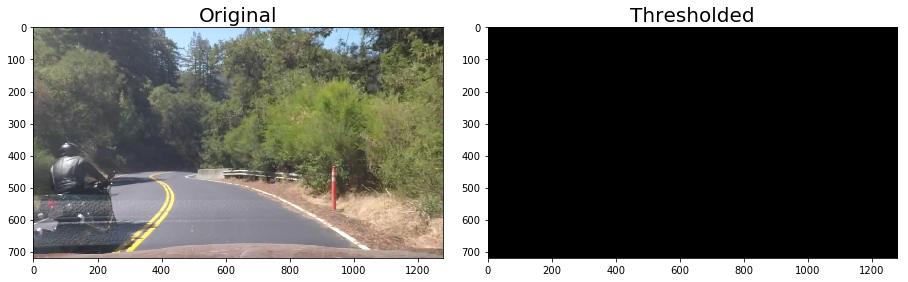

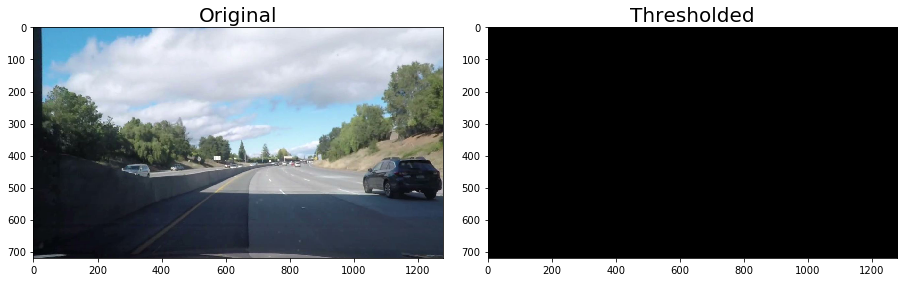

In [68]:
image = read_and_undistort('test_images/rt84.jpg')
image2 = read_and_undistort('test_images/bridge.jpeg')

def mask_it(image, h_min, h_max, s_min, s_max, v_min, v_max):
    h_binary = hls_channel_threshold(image, 'h', thresh=(h_min, h_max))
    s_binary = hls_channel_threshold(image, 's', thresh=(s_min, s_max))
    v_binary = hls_channel_threshold(image, 'l', thresh=(v_min, v_max))
    
    combined = np.zeros_like(h_binary)
    combined[((h_binary == 1) & (s_binary == 1) & (v_binary == 1))] = 255
    return combined

def make_multichannel(image):
    return np.uint8(np.dstack([image, image, image]))

def f(h_min, h_max, s_min, s_max, v_min, v_max):
    combined = mask_it(image, h_min, h_max, s_min, s_max, v_min, v_max)
    combined2 = mask_it(image2, h_min, h_max, s_min, s_max, v_min, v_max)

    merged = cv2.addWeighted(image, 1.0, make_multichannel(combined), 0.7, 0)
    merged2 = cv2.addWeighted(image2, 1.0, make_multichannel(combined2), 0.7, 0)
    show_before_and_after(image, combined, before_title="Original", after_title="Thresholded")
    show_before_and_after(image2, combined2, before_title="Original", after_title="Thresholded")

interact(f, h_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min H:"),
            h_max=widgets.IntSlider(min=0,max=178,step=1,value=178, continuous_update=False, description="Max H:"),
            s_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min S:"),
            s_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max S:"),
            v_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min V:"),
            v_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max V:"))

### RGB Thresholding

<function __main__.f>

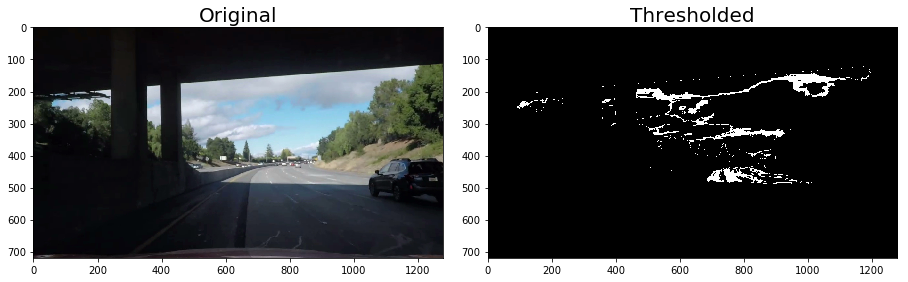

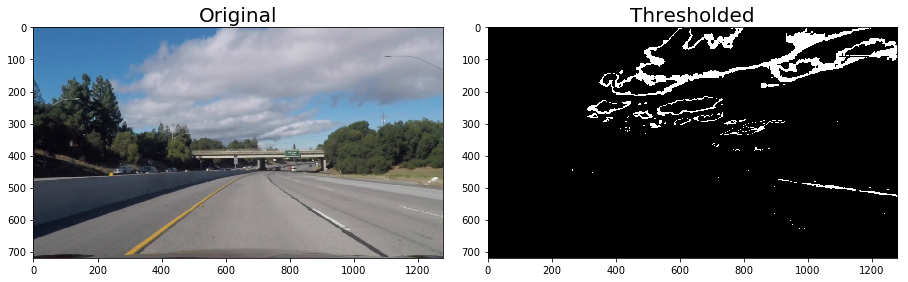

In [69]:
image = read_and_undistort('test_images/dark.jpg')
image2 = read_and_undistort('test_images/challenge_video.jpg')

def mask_it_rgb(image, r_min, r_max, g_min, g_max, b_min, b_max):
    r_binary = rgb_channel_threshold(image, 'r', thresh=(r_min, r_max))
    g_binary = rgb_channel_threshold(image, 'g', thresh=(g_min, g_max))
    b_binary = rgb_channel_threshold(image, 'b', thresh=(b_min, b_max))
    
    combined = np.zeros_like(r_binary)
    combined[((r_binary == 1) & (g_binary == 1) & (b_binary == 1))] = 255
    return combined

def f(r_min, r_max, g_min, g_max, b_min, b_max):
    combined = mask_it_rgb(image, r_min, r_max, g_min, g_max, b_min, b_max)
    combined2 = mask_it_rgb(image2, r_min, r_max, g_min, g_max, b_min, b_max)
    
    show_before_and_after(image, combined, before_title="Original", after_title="Thresholded")
    show_before_and_after(image2, combined2, before_title="Original", after_title="Thresholded")

interact(f, r_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min R:"),
            r_max=widgets.IntSlider(min=0,max=255,step=1,value=178, continuous_update=False, description="Max R:"),
            g_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min G:"),
            g_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max G:"),
            b_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min B:"),
            b_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max B:"))

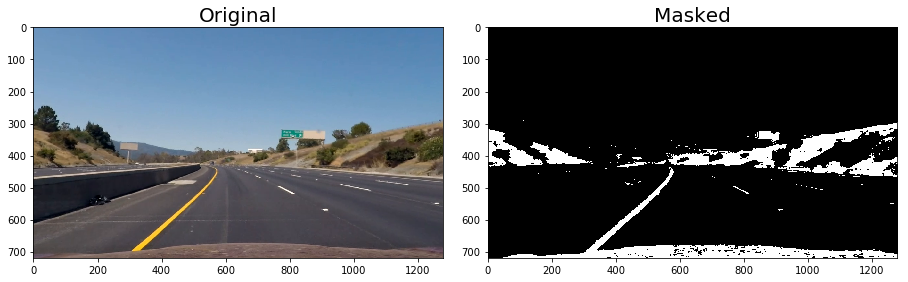

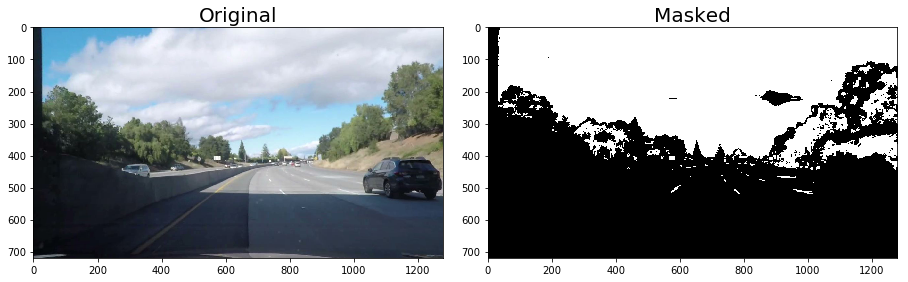

In [70]:
image = read_and_undistort('debug/images/frame10.jpg')
image2 = read_and_undistort('test_images/bridge.jpeg')

def color_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    boundaries = [
        ([ 0, 53, 100], [ 80, 255, 255]), # yellow
         #([ 0, 23, 45], [ 64, 189, 255]), # yellow
         ([23, 45, 184], [41, 255, 255]),
        #         ([ 0, 57, 90], [ 178, 209, 255]), # yellow
         ([  0,   0,   208], [ 178,  255, 255]) # white
    ]

    result = np.zeros((img.shape[0], img.shape[1]), dtype='uint8') 
    
    for lower, upper in boundaries:
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors we like
        mask = cv2.inRange(hsv, lower, upper)

        # and add it to our final one
        result = cv2.bitwise_or(result, mask)
    return result

result = color_mask(image)
show_before_and_after(image, result, before_title="Original", after_title="Masked")
result = color_mask(image2)
show_before_and_after(image2, result, before_title="Original", after_title="Masked")


### Sobel X

<function __main__.f>

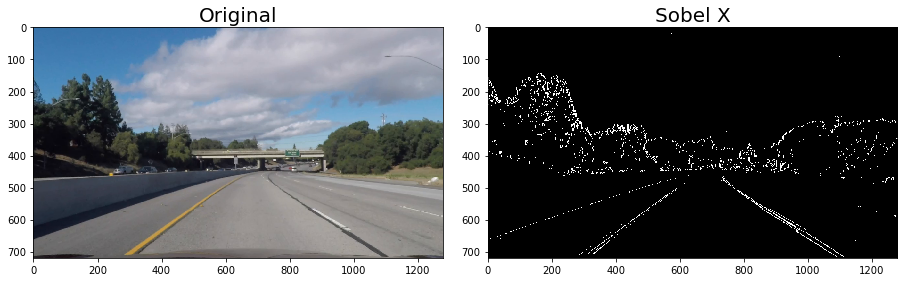

In [71]:
ksize = 3

image = read_and_undistort('test_images/challenge_video.jpg')

def f(x, y):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(x, y))
    show_before_and_after(image, gradx, before_title="Original", after_title="Sobel X")


interact(f, x=widgets.IntSlider(min=0,max=255,step=1,value=30, continuous_update=False, description="Min:"),
              y=widgets.IntSlider(min=0,max=255,step=1,value=100, continuous_update=False, description="Max:"))

### Sobel Y

<function __main__.f>

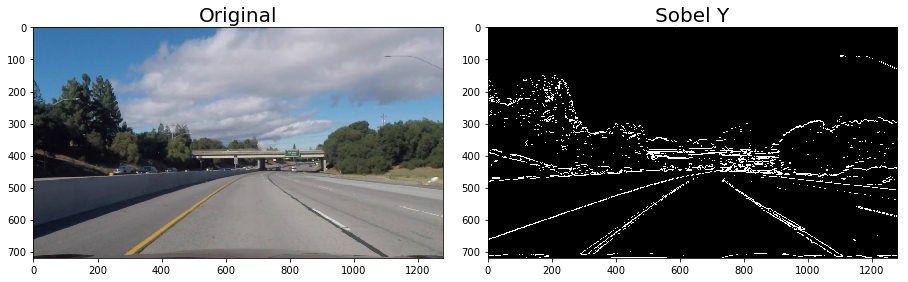

In [72]:
def f(x, y):
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(x, y))
    show_before_and_after(image, grady, before_title="Original", after_title="Sobel Y")


interact(f, x=widgets.IntSlider(min=0,max=255,step=1,value=30, continuous_update=False, description="Min:"),
              y=widgets.IntSlider(min=0,max=255,step=1,value=100, continuous_update=False, description="Max:"))

### Sobel Magnitude

<function __main__.f>

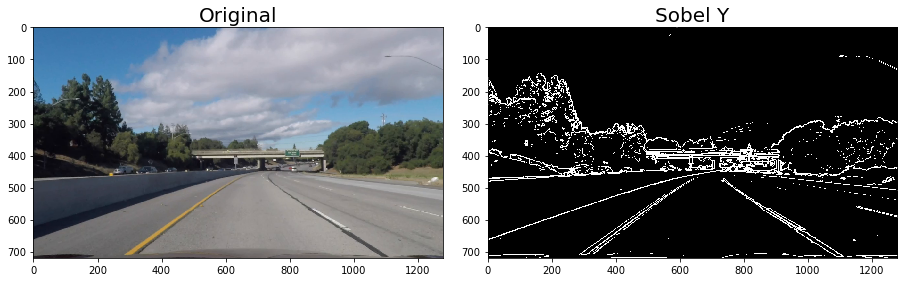

In [73]:
def f(x, y):
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(x, y))
    show_before_and_after(image, mag_binary, before_title="Original", after_title="Sobel Y")


interact(f, x=widgets.IntSlider(min=0,max=255,step=1,value=30, continuous_update=False, description="Min:"),
              y=widgets.IntSlider(min=0,max=255,step=1,value=200, continuous_update=False, description="Max:"))

### Sobel Directional

<function __main__.f>

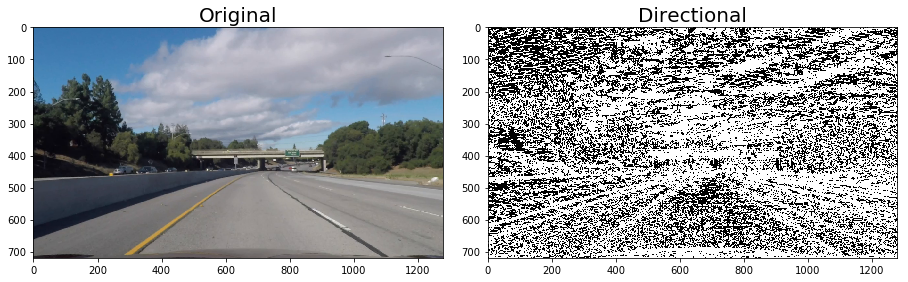

In [74]:
image = read_and_undistort('test_images/challenge_video.jpg')

def f(x, y):
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(x, y))
    show_before_and_after(image, dir_binary, before_title="Original", after_title="Directional")


interact(f, x=widgets.FloatSlider(min=0,max=np.pi,step=.01,value=0.7, continuous_update=False, description="Min:"),
              y=widgets.FloatSlider(min=0,max=np.pi,step=.01,value=2.9, continuous_update=False, description="Max:"))

## Warping

We need to warp the image in order to get a better viewpoint from which to detect the curvature of the road. So we apply an image transform to get a birds-eye view of the road.

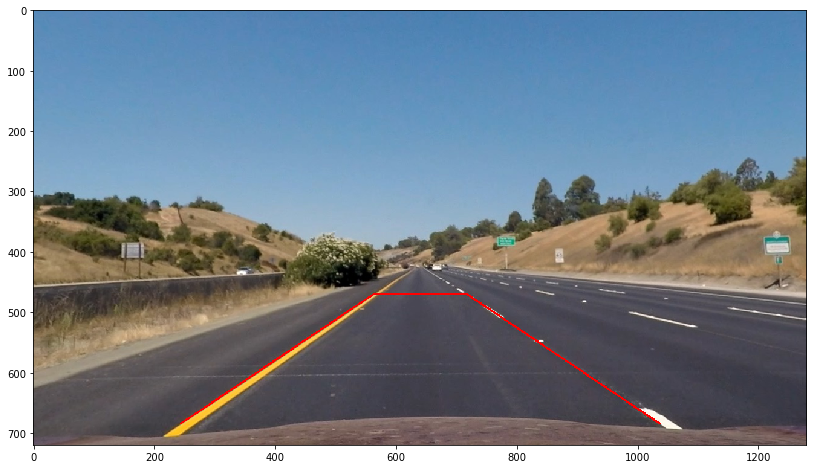

In [75]:
image = mpimg.imread('test_images/straight_lines1.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

image_size = (image.shape[1], image.shape[0])

width, height = image_size
midpoint = width // 2

# here we figure out what the points should be. I tried to leave
# the hood of the car out and follow the lines as best I could
# while using multipliers and not hard-coding any specific image
# coordinates.
bottom = height - int(height * 0.05) # leave out the hood
topOffset = int(width * .06)
bottomOffset = int(width * .31)
points = [(midpoint - bottomOffset, bottom),
          (midpoint - topOffset, height - int(height * .35)), 
          (midpoint + topOffset, height - int(height * .35)), 
          (midpoint + bottomOffset, bottom)]
imgcpy = np.copy(image)
draw_polyline(imgcpy, points)
plt.figure(figsize = (20,8))
plt.imshow(imgcpy)

Here we attempt to see the transformation at work. I picked a frame that was pretty twisty (been down this road on my own motorcycle :-)) and while I started with width / 4 as a starting point, based on the sample writeup, I found that pulling it inward gave me a better view of situations like this.

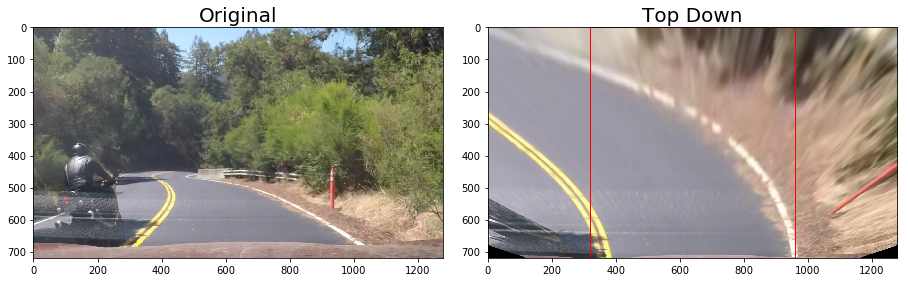

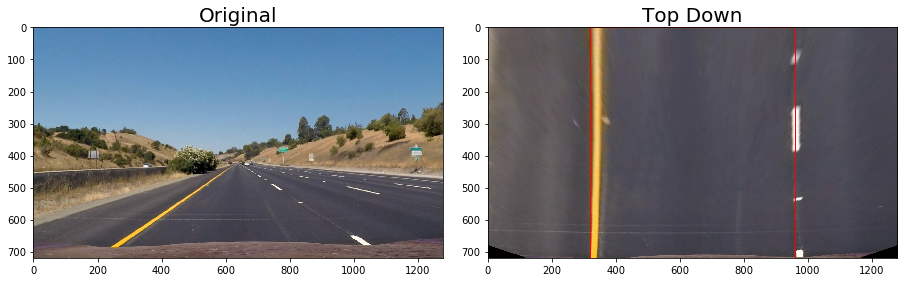

In [76]:
margin = width / 4
src = np.float32(points)
dst = np.float32([[margin, height],
                [margin, 0],
                [width - margin, 0],
                [width - margin, height]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

for filename in ['test_images/rt84.jpg', 'test_images/straight_lines1.jpg']:
    image = mpimg.imread(filename)
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    warped = cv2.warpPerspective(image, M, image_size)
    draw_polyline(warped, dst)
    mpimg.imsave("what.jpg", warped)
    show_before_and_after(image, warped, before_title="Original", after_title="Top Down")



Was playing with color range selection here.

In [77]:
our_settings = {}
our_settings['use_contrast'] = False
our_settings['gain'] = 10
our_settings['cutoff'] = 0.5
our_settings['use_grayscale'] = False
our_settings['sobel_x_min'] = 30
our_settings['sobel_x_max'] = 100
our_settings['sobel_y_min'] = 30
our_settings['sobel_y_max'] = 100


<function __main__.f>

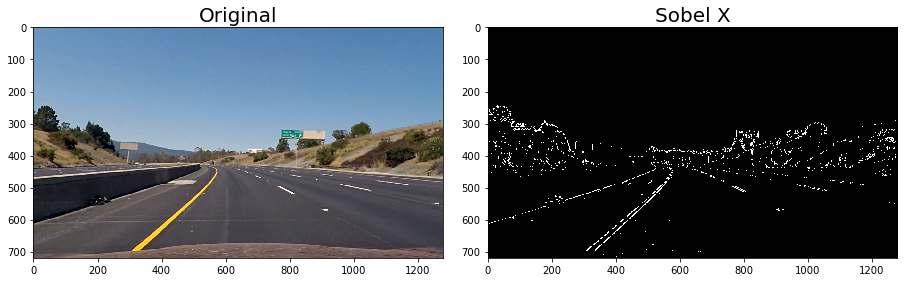

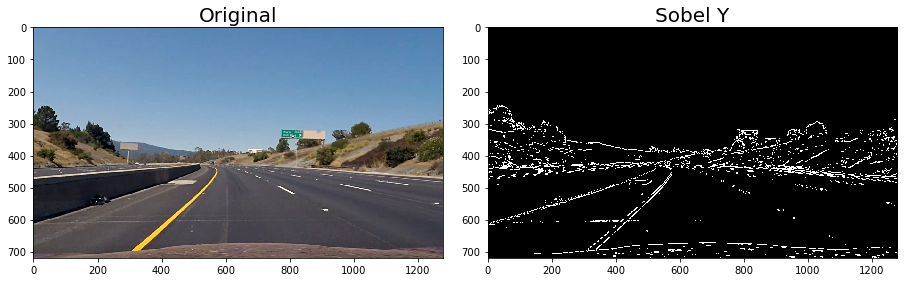

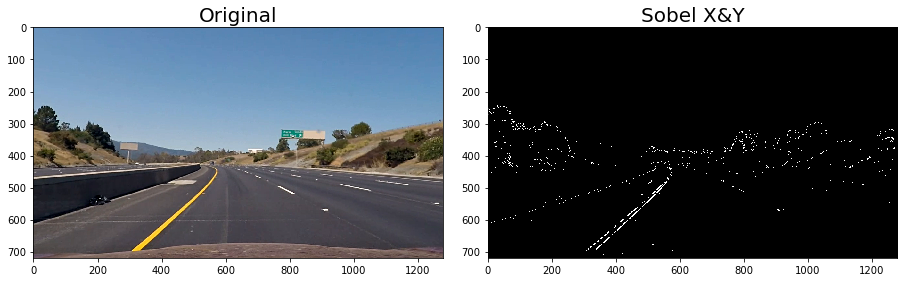

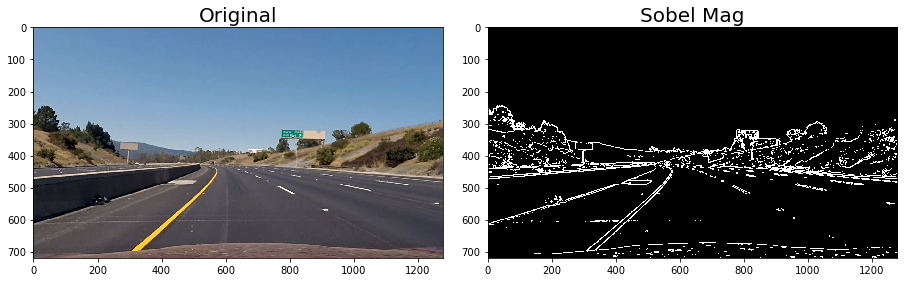

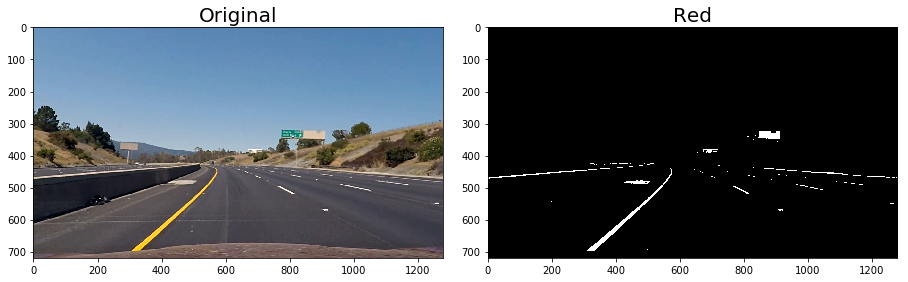

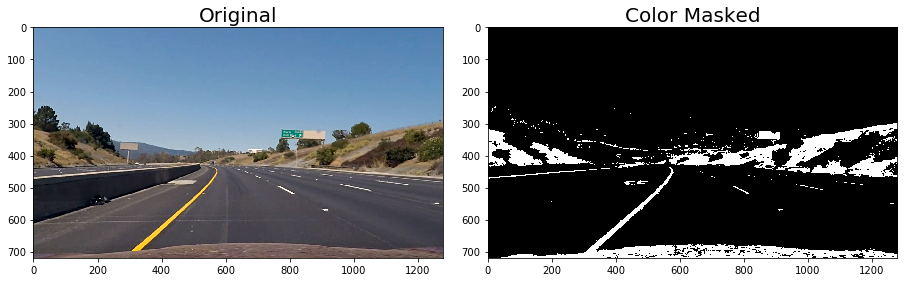

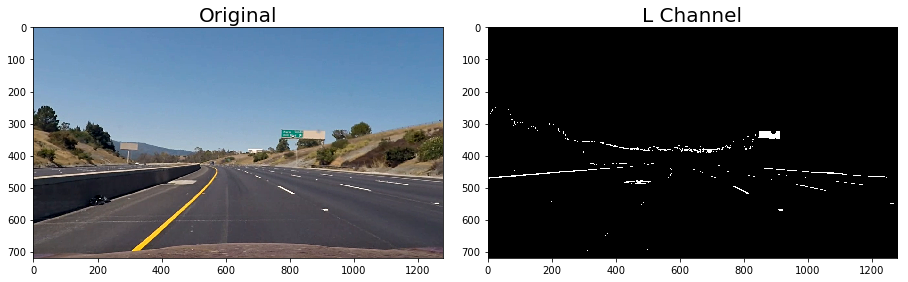

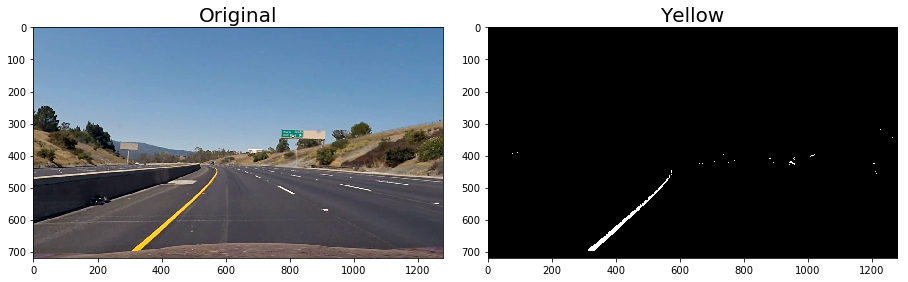

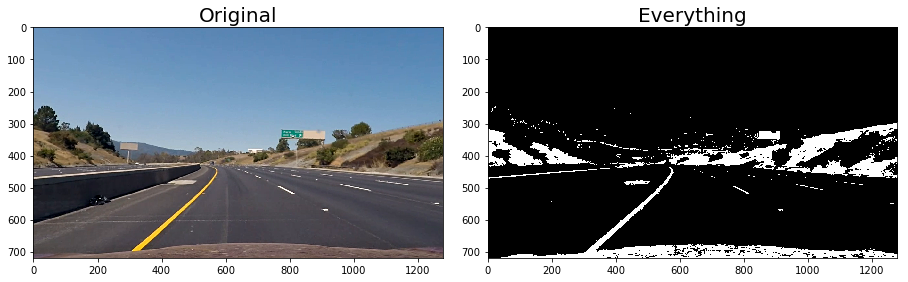

In [78]:
from skimage import exposure

def color_selection(img):
    boundaries = [
        #([200,200,200], [255,255,255]),
        ([170,170,0], [255,255,160])
    ]

    result = np.zeros((img.shape[0], img.shape[1]), dtype='uint8') 
    
    for lower, upper in boundaries:
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors we like
        mask = cv2.inRange(img, lower, upper)

        # and add it to our final one
        result = cv2.bitwise_or(result, mask)

    return result

def color_selection2(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    boundaries = [
        ([ 0, 100, 100], [ 50, 255, 255]),
        ([  0,   0,   180], [ 178,  20, 255])
    ]

    result = np.zeros_like(img) 

    for lower, upper in boundaries:
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors we like
        mask2 = cv2.inRange(hsv, lower, upper)

        # mask a white image with the mask
        fill = np.full(img.shape, 255, dtype = "uint8") 
        mask3 = cv2.bitwise_and(fill, fill, mask= mask2)

        # and add it to our final one
        result = cv2.add(result, mask3)
    return result

def color_mask2(img, lower, upper):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return cv2.inRange(hsv, np.uint8(lower), np.uint8(upper))

def yellow_mask(img):
    return cv2.inRange(img, np.array([ 150, 150, 0]), np.array([ 255, 255, 120]))

def prepare_image(filename):
    image = mpimg.imread(filename)
    if image.shape[2] == 4:
        image = image[:,:,:3]
        
    image = cv2.undistort(image, mtx, dist, None, mtx)
    
    # let's try a little sharpening
#     blur = cv2.GaussianBlur(image, (0,0), 3)
#     image = cv2.addWeighted(image, 1.5, blur, -0.5, 0)
    return image

def f(use_contrast, cutoff, gain, sobel_x_min, sobel_x_max):
    images = glob.glob('test_images/*.jpg')
    for filename in ['debug/images/frame10.jpg']:
        image = read_and_undistort(filename)
        blur = cv2.GaussianBlur(image, (0,0), 3)
        image = cv2.addWeighted(image, 1.5, blur, -0.5, 0)

        #image = cv2.warpPerspective(image, M, image_size)

        #image = (exposure.equalize_adapthist(image) * 255.0).astype(np.uint8)

        if use_contrast:
            image = exposure.adjust_sigmoid(image, cutoff=cutoff, gain=gain, inv=True)
            image = np.uint8(image / 1.0 * 255)

        sobelx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(sobel_x_min, sobel_x_max))
        sobely = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(sobel_x_min, sobel_x_max))
        sobelmag = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 200))
        sobeldir = dir_threshold(image, sobel_kernel=3, thresh=(0.04, 0.45))


        sat_binary = hls_channel_threshold(image, 's', thresh=(0, 48))
#         hue_binary = hls_channel_threshold(image, 'h', thresh=(x, y))
        light_binary = hls_channel_threshold(image, 'l', thresh=(190, 255))
        red_binary = rgb_channel_threshold(image, 'r', thresh=(200, 255))

        yellow_binary = yellow_mask(image)
        yellow_binary = (yellow_binary // 255).astype(np.uint8)
        
        mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 200))
        
        mask = color_mask(image)
        mask_binary = (mask // 255).astype(np.uint8)
        
        another_yellow = color_mask2(image, [23, 45, 184], [41, 255, 255])
        another_yellow_binary = (another_yellow // 255).astype(np.uint8)
        
        combined_yellow = np.zeros_like(another_yellow)
        combined_yellow[(yellow_binary == 1) | (another_yellow_binary == 1)] = 255

        
        sobel_xy = np.zeros_like(red_binary)
        sobel_xy[(sobelx == 1) & (sobely == 1)] = 1
        
        combination1 = (mask_binary == 1) | (light_binary == 1) | (yellow_binary == 1)
        combination2 = (sobelx == 1) | (sobely == 1)# | (sobeldir == 1)
        
        all_yellow = (yellow_binary == 1) | (another_yellow_binary == 1)
        red_and_light = (red_binary == 1) & (light_binary == 1)
        
        everything = np.zeros_like(red_binary)
        everything[all_yellow | (mask_binary ==1) | (red_binary == 1)] = 255
        # everything[(combination1 & combination2) | all_yellow] = 255
#        everything[((mask_binary == 1) & (sobelx == 1))] = 1

        our_settings['use_contrast'] = use_contrast
        our_settings['gain'] = gain
        our_settings['cutoff'] = cutoff
        our_settings['sobel_x_min'] = sobel_x_min
        our_settings['sobel_x_max'] = sobel_x_max

        show_before_and_after(image, sobelx, before_title="Original", after_title="Sobel X")
        show_before_and_after(image, sobely, before_title="Original", after_title="Sobel Y")
        show_before_and_after(image, sobel_xy, before_title="Original", after_title="Sobel X&Y")
        show_before_and_after(image, sobelmag, before_title="Original", after_title="Sobel Mag")
        show_before_and_after(image, red_binary, before_title="Original", after_title="Red")
        show_before_and_after(image, mask, before_title="Original", after_title="Color Masked")
        show_before_and_after(image, light_binary, before_title="Original", after_title="L Channel")
        show_before_and_after(image, yellow_binary, before_title="Original", after_title="Yellow")
        show_before_and_after(image, everything, before_title="Original", after_title="Everything")

interact(f, use_contrast=widgets.Checkbox(value=our_settings['use_contrast'], description='Set Contrast', disabled=False),
            cutoff=widgets.FloatSlider(min=0,max=1.0,step=.01,value=our_settings['cutoff'], continuous_update=False, description="Cutoff:"),
            gain=widgets.IntSlider(min=0,max=50,step=1,value=our_settings['gain'], continuous_update=False, description="Gain:"),
            sobel_x_min=widgets.IntSlider(min=0,max=255,step=1,value=our_settings['sobel_x_min'], continuous_update=False, description="Sobel Min:"),
            sobel_x_max=widgets.IntSlider(min=0,max=178,step=1,value=our_settings['sobel_x_max'], continuous_update=False, description="Sobel Max:")
)


Here I establish a settings object which I can save and reuse. I can fiddle with the settings below and they are used as our defaults later.

In [79]:
def enhance_lines_using_settings(image):
    #mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 200))
    sat_binary = hls_channel_threshold(image, 's', thresh=(170, 255))
    light_binary = hls_channel_threshold(image, 'l', thresh=(210, 255))
    red_binary = rgb_channel_threshold(image, 'r', thresh=(170, 255))
    sobelx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(22, 124))
    sobely = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(22, 124))
    sobelmag = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 200))
    mask_binary = (color_mask(image) / 255).astype(np.uint8)
    sobeldir = dir_threshold(image, sobel_kernel=3, thresh=(0.04, 0.45))

    combined = np.zeros_like(red_binary)
    combined[(((red_binary == 1) | (mask_binary == 1))
                & ((sobelx == 1) | (sobely == 1) | (sobelmag == 1)))] = 1
    
    yellow_binary = yellow_mask(image)
    yellow_binary = (yellow_binary // 255).astype(np.uint8)
    another_yellow = color_mask2(image, [23, 45, 184], [41, 255, 255])
    another_yellow_binary = (another_yellow // 255).astype(np.uint8)

    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 200))

    mask = color_mask(image)
    mask_binary = (mask // 255).astype(np.uint8)

    combination1 = (mask_binary == 1) | (light_binary == 1) | (yellow_binary == 1)
    combination2 = (sobelx == 1) | (sobely == 1)# | (sobeldir == 1)

    everything = np.zeros_like(red_binary)
    everything[(combination1 & combination2)] = 255

    return everything


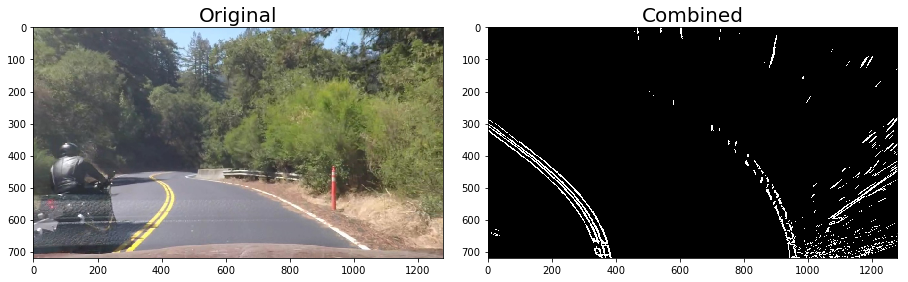

In [80]:
image = read_and_undistort('test_images/rt84.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
warped = cv2.warpPerspective(undist, M, image_size)

processed = enhance_lines_using_settings(warped)
show_before_and_after(image, processed, before_title="Original", after_title="Combined")


Use the above now for a different test image.

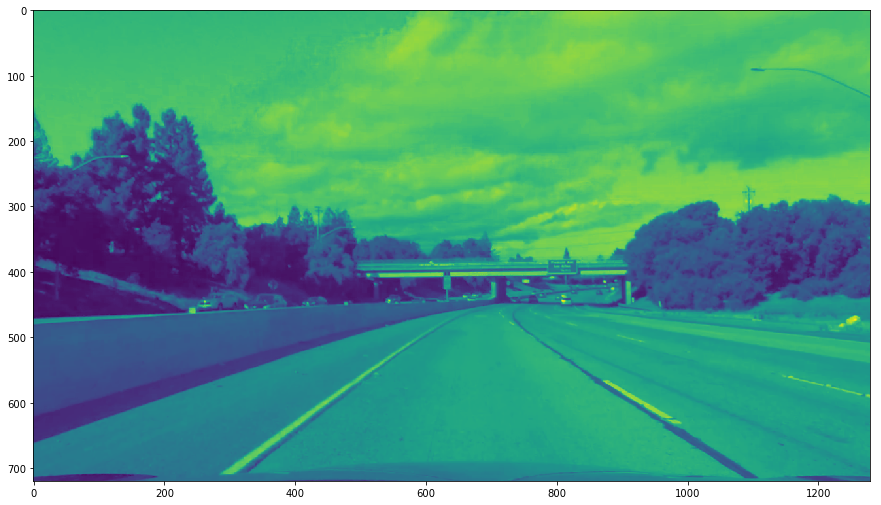

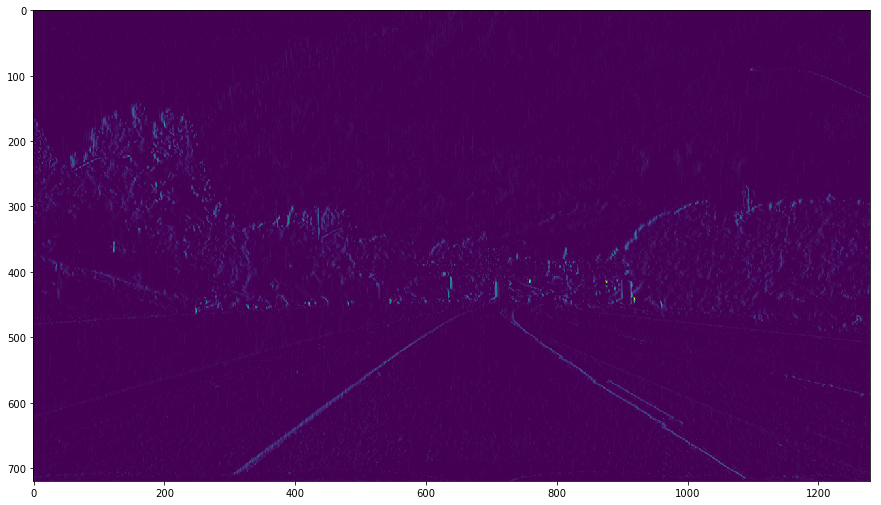

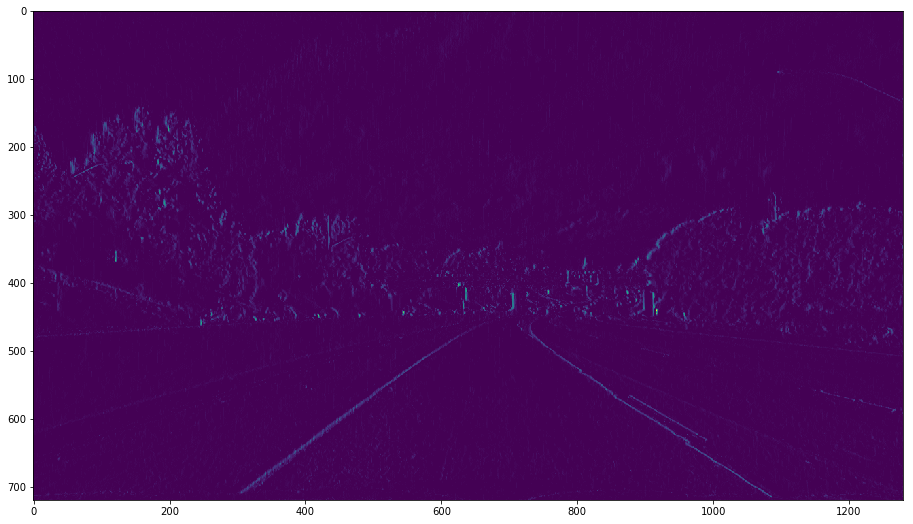

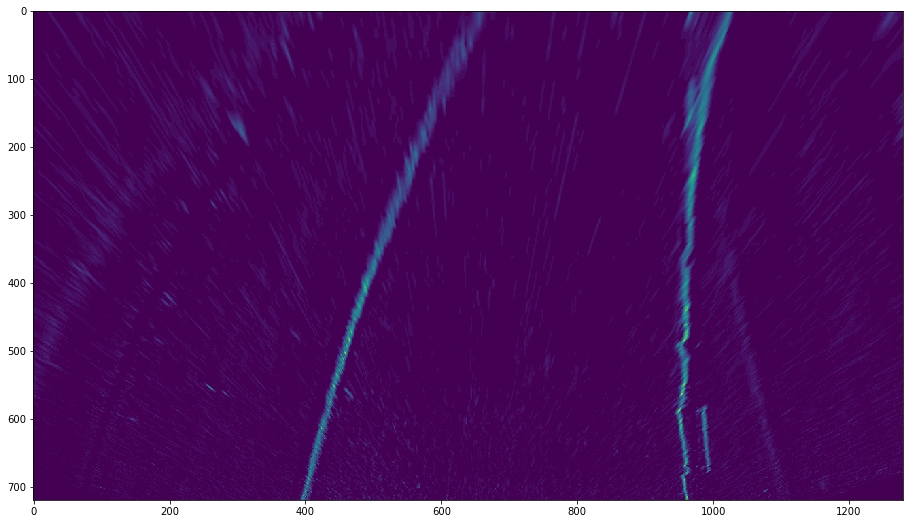

In [81]:
image = read_and_undistort('test_images/challenge_video.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
channel_data = hsv[:,:,2]

plt.figure(figsize=(15,9))
plt.imshow(channel_data)

filtered = cv2.filter2D(channel_data, -1, np.array([[0, 1, -1, 0, 0]]))

plt.figure(figsize=(15,9))
plt.imshow(filtered)

filtered = cv2.filter2D(channel_data, -1, np.array([[0, 0, 0, 1, -1]]))

plt.figure(figsize=(20,9))
plt.imshow(filtered)

warped = cv2.warpPerspective(filtered, M, image_size)
plt.figure(figsize=(20,9))
plt.imshow(warped)



In [82]:
image = read_and_undistort('test_images/challenge_video.jpg')
warped = cv2.warpPerspective(image, M, image_size)
enhanced = enhance_lines_using_settings(warped)
print(enhanced.shape, np.max(enhanced))
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(enhanced, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(enhanced)
    r_points = np.zeros_like(enhanced)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,enhanced,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,enhanced,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((enhanced,enhanced,enhanced)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((enhanced,enhanced,enhanced)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

(720, 1280) 255


ValueError: object too deep for desired array